## Imports

In [7]:
import os
import sys
import glob
import logging

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from monai.transforms import (
    LoadImage,
    EnsureChannelFirst,
    Compose,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    EnsureType,
    Transform,
    Resize,
    CenterSpatialCrop,
    AdjustContrast
)

from monai.data import CacheDataset, DataLoader
from monai.visualize import matshow3d
from monai.utils import first, set_determinism
from monai.apps import get_logger

## Determinism, device and logger

In [8]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
2
0
NVIDIA TITAN RTX


In [9]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
get_logger('train_log')
set_determinism(0)
device = torch.device('cuda:0')

In [10]:
torch.cuda.empty_cache()
torch.cuda.memory_stats()
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

## Load and prepare dataset

In [11]:
image_size = 128
num_slices = 128
contrast_gamma = 1.5
every_n_slice = 8
batch_size = 1

learning_rate = 1e-4
channels = 1
num_epochs = 100
latent_size = 100
critic_features = 16
generator_features = 16
critic_iterations = 5
lambda_gp = 10

In [12]:
data_dir = '/data1/dose-3d-generative/data_med/PREPARED/FOR_AUG'
directory = os.path.join(data_dir, 'ct_images')
images_pattern = os.path.join(directory, '*.nii.gz')
images = sorted(glob.glob(images_pattern))[:1]

train_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        CenterSpatialCrop((400, 400, 0)),
        Resize((image_size, image_size, num_slices)),
        ScaleIntensity(),
        AdjustContrast(contrast_gamma),
        RandRotate(range_x=np.pi/12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureType()
    ]
)

dataset = CacheDataset(images, train_transforms)
loader = torch.utils.data.DataLoader(dataset, num_workers=10, shuffle=True, pin_memory=torch.cuda.is_available())

Loading dataset: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


(1, 1, 128, 128, 128)


(<Figure size 1000x1000 with 1 Axes>,
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        ...,
        [nan,  0.,  0., ...,  0.,  0., nan],
        [nan,  0.,  0., ...,  0.,  0., nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32))

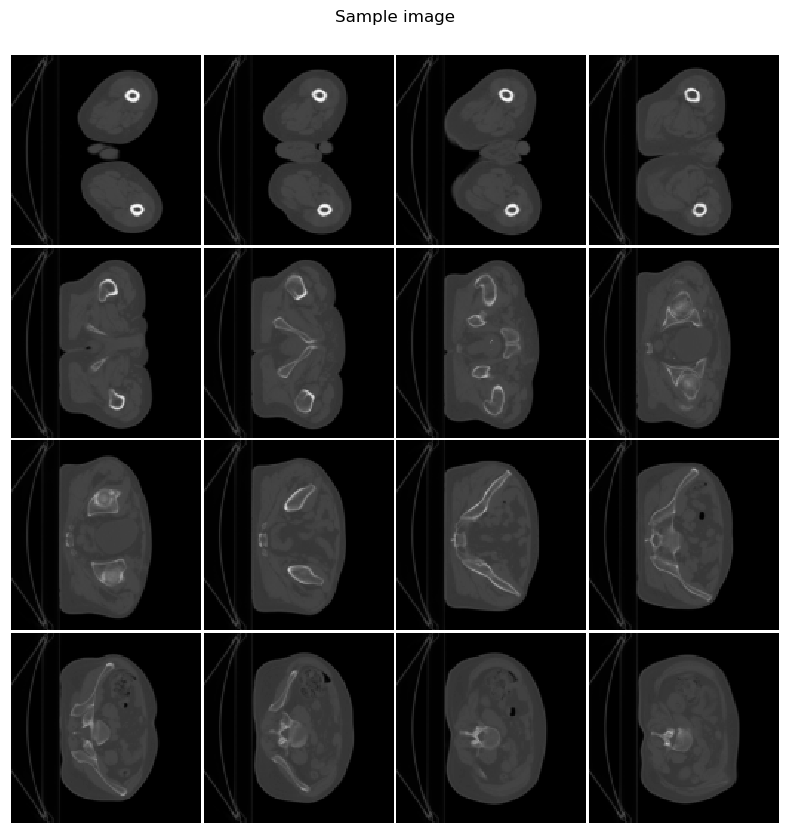

In [13]:
image_sample = first(loader)
print(image_sample.shape)

fig = plt.figure(figsize=(15,15))
matshow3d(volume=image_sample,
          fig=fig,
          title="Sample image",
          every_n=every_n_slice,
          frame_dim=-1,
          cmap="gray")

## Define model architecture

In [15]:
from monai.networks.layers.simplelayers import Reshape

class Critic(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Critic, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 128 x 128 x 128
            nn.Conv3d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            self._block(features_d * 8, features_d * 16, 4, 2, 1),
            # After all _block img output is 4x4x4 (Conv3d below makes into 1x1)
            nn.Conv3d(features_d * 16, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv3d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32x32
            self._block(features_g * 2, features_g, 4, 2, 1),  # img: 64x64x64
            nn.ConvTranspose3d(
                features_g, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 128 x 128 x 128
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose3d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv3d, nn.ConvTranspose3d, nn.BatchNorm3d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

def gradient_penalty(critic, real, fake, device='cpu'):
    batch_size, c, h, w, d = real.shape
    alpha = torch.rand((batch_size, 1, 1, 1, 1)).repeat(1, c, h, w, d).to(device)

    # calculate interpolated/mean images using random vector alpha and 1-alpha
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)

    return gradient_penalty

def test():
    N, in_channels, H, W, D = 1, 1, 256, 256, 128
    noise_dim = 256
    x = torch.randn((N, in_channels, H, W, D))
    disc = Critic(in_channels, 8)
    #out = disc(x)
    #print(out.shape)
    #out = out.reshape(-1)
    #print(out.shape)
    #assert disc(x).shape == (N, 1, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, 256, 8, 8, 4))
    #print(z.shape)
    print(gen(z).shape)
    assert gen(z).shape == (N, in_channels, H, W, D), "Generator test failed"
    print("Success, tests passed!")

#test()

## Initialize and train model

In [16]:
# create and initialize networks

critic = Critic(channels, critic_features).to(device)
initialize_weights(critic)

generator = Generator(latent_size, channels, generator_features).to(device)
initialize_weights(generator)

In [17]:
# initialize optimizers

opt_critic = optim.Adam(critic.parameters(), lr=learning_rate, betas=(0.0, 0.9))
opt_generator = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.0, 0.9))

In [19]:
noise = torch.randn(1, latent_size, 1, 1, 1).to(device)
step = 0

critic.train()
generator.train()

for epoch in range(num_epochs):
    curr_epoch_loss_gen_sum = 0
    curr_epoch_loss_crit_sum = 0
    for batch_idx, real in enumerate(loader):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
        for _ in range(critic_iterations):
            noise = torch.randn(cur_batch_size, latent_size, 1, 1, 1).to(device)
            fake = generator(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + lambda_gp * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        generator_fake = critic(fake).reshape(-1)
        loss_generator = -torch.mean(generator_fake)
        generator.zero_grad()
        loss_generator.backward()
        opt_generator.step()
        #writer_loss_step.add_scalar("Step loss Gen", loss_gen, global_step=step)
        #writer_loss_step.add_scalar("Step loss Crit", loss_critic, global_step=step)
        curr_epoch_loss_gen_sum += loss_generator.item()
        curr_epoch_loss_crit_sum += loss_critic.item()
        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_generator:.4f}"
            )

            with torch.no_grad():
                fake = generator(noise)
                #fig_real = plt.figure(figsize=(15,15))
                #matshow3d(volume=real, fig=fig_real, title="real", every_n=2, frame_dim=-1, cmap="gray")
                #fig_fake = plt.figure(figsize=(15,15))
                #matshow3d(volume=fake, fig=fig_fake, title="fake", every_n=2, frame_dim=-1, cmap="gray")
                #img2tensorboard.plot_2d_or_3d_image(data=real, step=step, writer=writer_real_gif, frame_dim=-1)
                #img2tensorboard.plot_2d_or_3d_image(data=fake, step=step, writer=writer_fake_gif, frame_dim=-1)
                
                #writer_real.add_figure("Real", fig_real, global_step=step)
                #writer_fake.add_figure("Fake", fig_fake, global_step=step)

        step += 1

    loss_gen_epoch = curr_epoch_loss_gen_sum / len(loader)
    loss_crit_epoch = curr_epoch_loss_crit_sum / len(loader)
    print(f"Generator mean loss in epoch:{loss_gen_epoch}")
    #writer_loss_epoch.add_scalar("Epoch loss Gen", loss_gen_epoch, global_step=epoch)
    #writer_loss_epoch.add_scalar("Epoch loss Crit", loss_crit_epoch, global_step=epoch)

Epoch [0/100] Batch 0/1                   Loss D: 2.6694, loss G: 0.1652
Generator mean loss in epoch:0.16516533493995667
Epoch [1/100] Batch 0/1                   Loss D: -0.6842, loss G: 0.3054
Generator mean loss in epoch:0.30540019273757935
Epoch [2/100] Batch 0/1                   Loss D: -1.2648, loss G: 0.4887
Generator mean loss in epoch:0.48866939544677734
Epoch [3/100] Batch 0/1                   Loss D: -0.5502, loss G: 0.6366
Generator mean loss in epoch:0.6366451382637024
Epoch [4/100] Batch 0/1                   Loss D: -1.2841, loss G: 0.8269
Generator mean loss in epoch:0.8268616795539856
Epoch [5/100] Batch 0/1                   Loss D: -2.4972, loss G: 1.0277
Generator mean loss in epoch:1.0277059078216553
Epoch [6/100] Batch 0/1                   Loss D: -2.3208, loss G: 1.2517
Generator mean loss in epoch:1.2517393827438354
Epoch [7/100] Batch 0/1                   Loss D: -4.0927, loss G: 1.4982
Generator mean loss in epoch:1.4982043504714966
Epoch [8/100] Batch 0/